In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from oodeel.methods import MLS, ODIN
from oodeel.eval.metrics import bench_metrics
from oodeel.datasets import OODDataset
from oodeel.models.training_funs import train_convnet_classifier

from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
os.makedirs(model_path, exist_ok=True)

## MNIST vs Fashion MNIST

* In-distribution data: MNIST 
* Out-of-distribution data: Fashion MNIST

### Load and prepare the datasets

This is performed using the class `OODDataset`. First, load the datasets.

In [2]:
oods_in = OODDataset('mnist', split="test")
oods_out = OODDataset('fashion_mnist', split="test")
oods_fit = OODDataset('mnist', split="train")

Then, prepare the dataset for scoring and/or training using `.prepare` method.

In [3]:
def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

batch_size = 128

ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_fit = oods_fit.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

Train or load a model on in-distribution data (MNIST)

In [4]:
model_path_mnist = os.path.join(model_path, "mnist_model.h5")

try:
    model = tf.keras.models.load_model(model_path_mnist)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in#.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier(ds_fit, **train_config) #ds_fit is actually the train set of MNIST
    model.summary()

### Maximum Logit Score (MLS)

Return an OOD score based on the maximum value of the output logits.

In [5]:
oodmodel = MLS()
oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)

Compute the evaluation metrics based on the scores of the test data, and visualize the scores histogram.

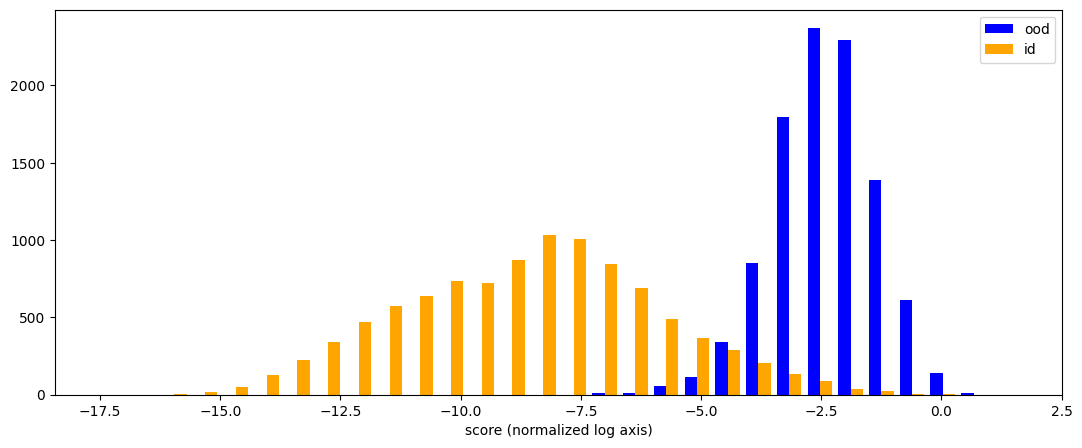

auroc             0.984372
fpr95tpr          0.051200
accuracy_score    0.539150
roc_auc_score     0.984372
dtype: float64


In [6]:
metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -7.5 # visually chosen based on the plot
    )

def plot_hist(scores_in, scores_out, bins, log=False):
    if log:
        minim = np.min([np.min(scores_in), np.min(scores_out)])
        scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        _, bins = np.histogram(np.concatenate([scores_in_, scores_out_]), bins=30)
        logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
        plt.xscale('log')
        plt.xlabel("score (normalized log axis)")
    else:
        logbins=bins
        scores_in_ = scores_in 
        scores_out_ = scores_out
        plt.xlabel("score")
    plt.hist((scores_out_, scores_in_), bins=logbins, color=("blue", "orange"), label=("ood", "id"))
    plt.legend()
    plt.show()

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30)
metrics = pd.Series(metrics)
print(metrics)


### Maximum Softmax Score (MSS)

It is possible to do the same after the softmax activation.

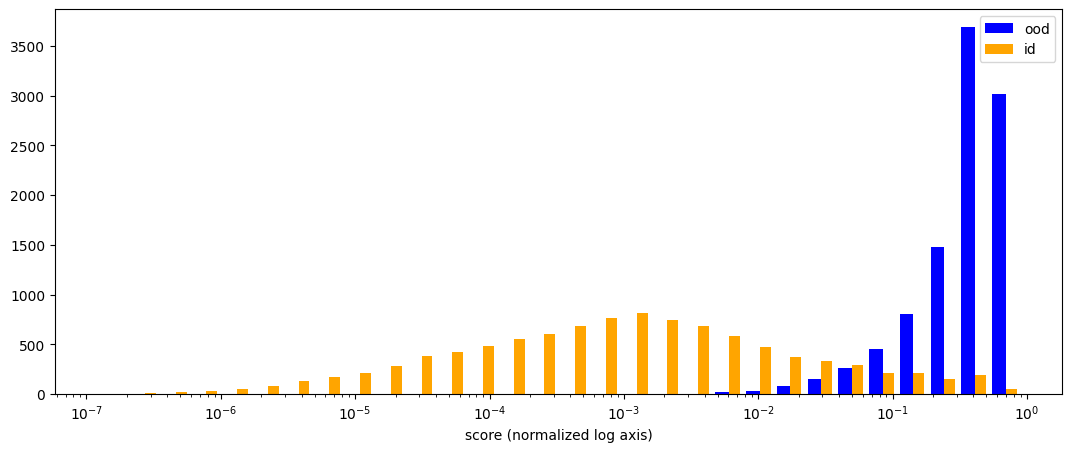

auroc             0.976113
fpr95tpr          0.087600
accuracy_score    0.931950
roc_auc_score     0.976113
dtype: float64


In [7]:
oodmodel = MLS(output_activation="softmax")
oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)

metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -0.95 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30, log=True)
metrics = pd.Series(metrics)
print(metrics)

## MNIST (0-4) vs MNIST (5-9)

* In-distribution data: MNIST (0-4)
* Out-of-distribution data: MNIST (5-9)

We can repeat the procedure in an open-set-recognition or semantic OOD setting by considering a subset of MNIST lasses as in-distribution and another subset as out-of-distribution. The datasets are constructed using the `OODDataset` method `.assign_ood_labels_by_class`. First load and split the dataset.

In [8]:
oods_fit = OODDataset('mnist', split="train")
oods_test = OODDataset('mnist', split="test")

batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
oods_fit, _ = oods_fit.assign_ood_labels_by_class(in_labels=inc_labels)
oods_in, oods_out = oods_test.assign_ood_labels_by_class(in_labels=inc_labels)

Then prepare the datasets for scoring and/or training.

In [9]:

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

ds_fit = oods_fit.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)


Train or load the model.

In [10]:
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4.h5")

try:
    model = tf.keras.models.load_model(model_path_mnist_04)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "is_prepared": True,
        "batch_size": 128,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier(ds_fit, **train_config) #ds_fit is actually the train set of MNIST

### Maximum Logit Score (MLS)

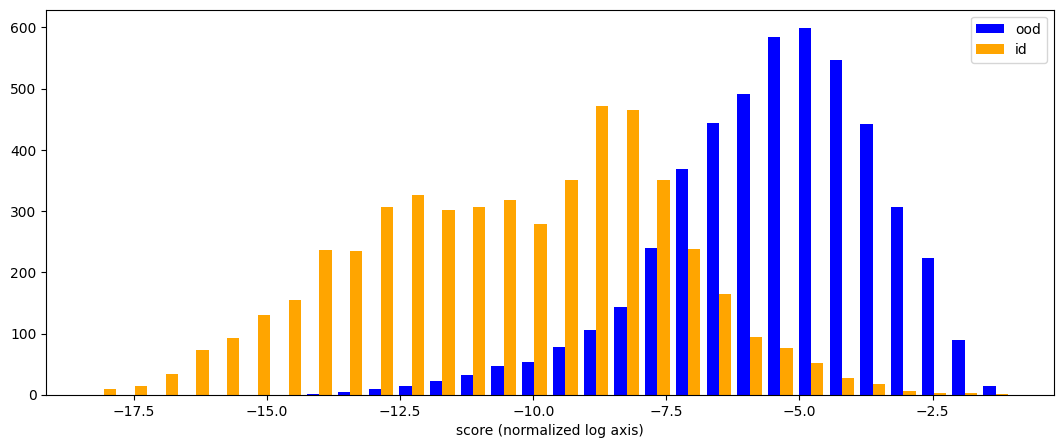

auroc             0.923506
fpr95tpr          0.395797
accuracy_score    0.513900
roc_auc_score     0.923507
dtype: float64


In [11]:
oodmodel = MLS()
oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -7.5 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30)
metrics = pd.Series(metrics)
print(metrics)

### Maximum Softmax Score (MSS)

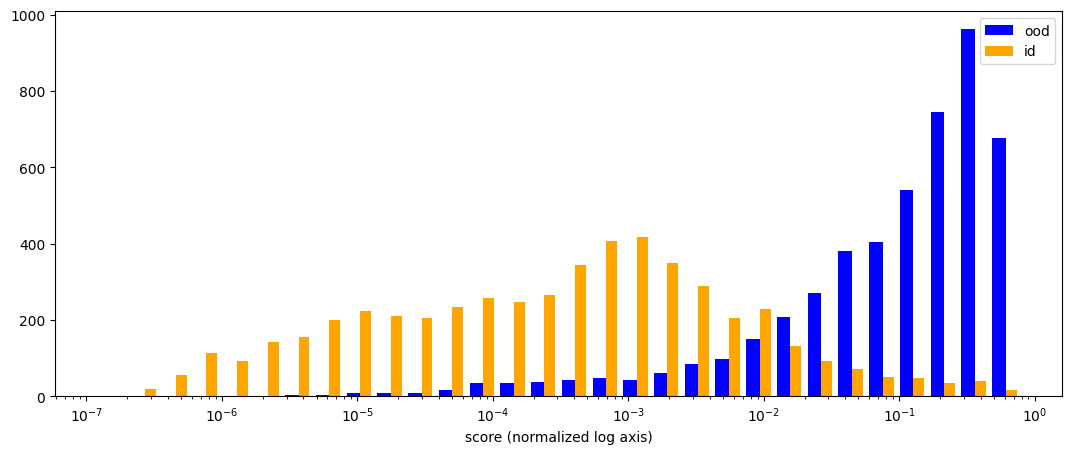

auroc             0.935694
fpr95tpr          0.374003
accuracy_score    0.513900
roc_auc_score     0.935693
dtype: float64


In [12]:
oodmodel = MLS(output_activation="softmax")
oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -0.95 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30, log=True)
metrics = pd.Series(metrics)
print(metrics)